

Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/04/02


In [129]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd
import scipy
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm

sb.set_style('darkgrid')

# Predicting Property Crime from Population, Murder and Robbery statistics. 

In [130]:
data_path  = '/media/ianh/space/ThinkfulData/NYCrimeData/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013 - 13tbl8ny.csv'
data = pd.read_csv(data_path, usecols=['Property crime', 'City','Population', 'Robbery', 'Burglary', 'Murder'])
data.head()

,City,Population,Murder,Robbery,Property crime,Burglary
0,Adams Village,1861,0,0,12,2
1,Addison Town and Village,2577,0,0,24,3
2,Akron Village,2846,0,0,16,1
3,Albany,97956,8,227,4090,705
4,Albion Village,6388,0,4,223,53


Running Multiple Regression on the data to inspect model results before any data transformation is carried out to appease assumptions of multiple linear regression.


$$Property Crime = \alpha + \beta_1Population+ \beta_2Robbery + \beta_3Burglary + \beta_4Murder$$

In [131]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Property crime'].values.reshape(-1, 1)
X = data[['Population','Robbery','Burglary', 'Murder']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.01260332 -0.66869531  3.12379333 -8.68111929]]

Intercept: 
 [-23.52356583]

R-squared:
0.999587659128


The R-squared value appears too good to be true.  Our model can account for 99 % of variance in the outcome variable? 

### Multivariate normality

The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed.  Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

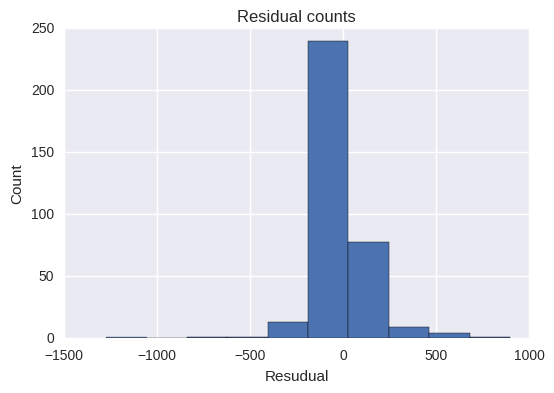

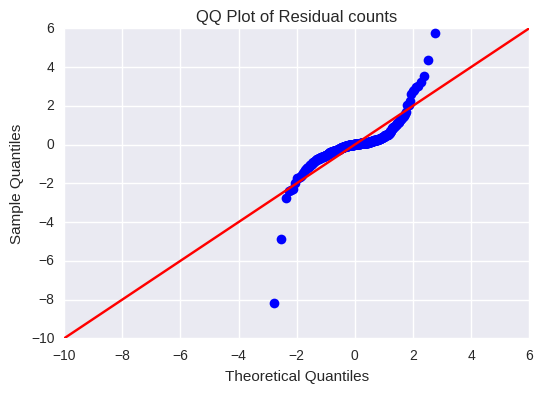

In [132]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Property crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Resudual')
plt.ylabel('Count')
plt.show()


sm.graphics.qqplot(residual, line='45', fit=True)
plt.title('QQ Plot of Residual counts')
plt.show()

The above histogram and QQ Plot do not depict a normal distribution for the residuals. This is to be expected before any data transformations are carried out. No data is ever prefect and ready to be analyzed.

### Homoscedasticity

The distribution of the error terms (its "scedasticity"), should be consistent for all predicted values, or **homoscedastic**.

For example, if your error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance.  This leads to overconfidence in the accuracy of your model's predictions.

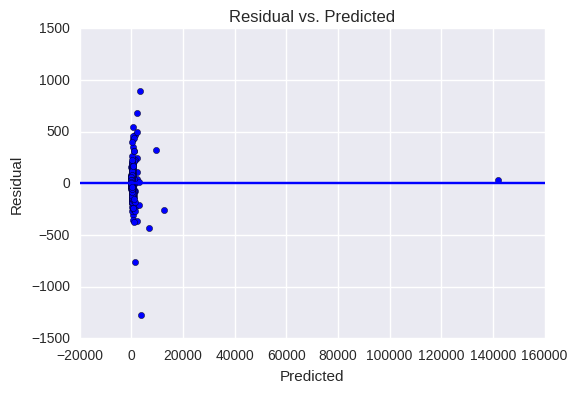

In [133]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

###  Low multicollinearity

Correlations among features should be low or nonexistent.  When features are correlated, they may both explain the same pattern of variance in the outcome.  Realistically, for this data set it is highly unlikely that some forms of crime like burglary  and robbery are not correlated. It is easy to imagine that individuals perform multiple crime types. 

In [134]:
correlation_matrix = X.corr()
display(correlation_matrix)

,Population,Robbery,Burglary,Murder
Population,1.000000,0.998469,0.970578,0.986758
Robbery,0.998469,1.000000,0.979525,0.993104
Burglary,0.970578,0.979525,1.000000,0.993733
Murder,0.986758,0.993104,0.993733,1.000000


In [135]:
def retrieve_metadata(dataframe):
    """
     Extracts the shape, column names and number of null rows for
     each column of a Pandas data frame. This information is printed
     to standard ouput.

     Args:
        dataframe (dataframe): The Pandas data frame of interest

     Returns:
        Nothing
    """
    num_rows, num_columns = dataframe.shape
    columns = dataframe.columns.values.tolist()
    print('Data frame contains %d columns and %d rows' % (num_columns, num_rows))
    for elem in columns:
        print('\ncolumn %s has %d empty rows'% (elem, sum(dataframe[elem].isnull())))
        print('column %s statistics\n%s\n'% (elem, dataframe[elem].describe()))

Look for missing and mis typed column data. In addition, view some basic statistics on the read in column data. 

In [136]:
retrieve_metadata(data)

Data frame contains 6 columns and 348 rows

column City has 0 empty rows
column City statistics
count                        348
unique                       348
top       St. Johnsville Village
freq                           1
Name: City, dtype: object


column Population has 0 empty rows
column Population statistics
count    3.480000e+02
mean     4.003763e+04
std      4.500374e+05
min      5.260000e+02
25%      3.003000e+03
50%      7.233500e+03
75%      1.842750e+04
max      8.396126e+06
Name: Population, dtype: float64


column Murder has 0 empty rows
column Murder statistics
count    348.000000
mean       1.566092
std       18.303673
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      335.000000
Name: Murder, dtype: float64


column Robbery has 0 empty rows
column Robbery statistics
count      348.000000
mean        72.902299
std       1031.032873
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max      1

Create new column that is the square of the Population feature and create scatter plots to view possible associations.

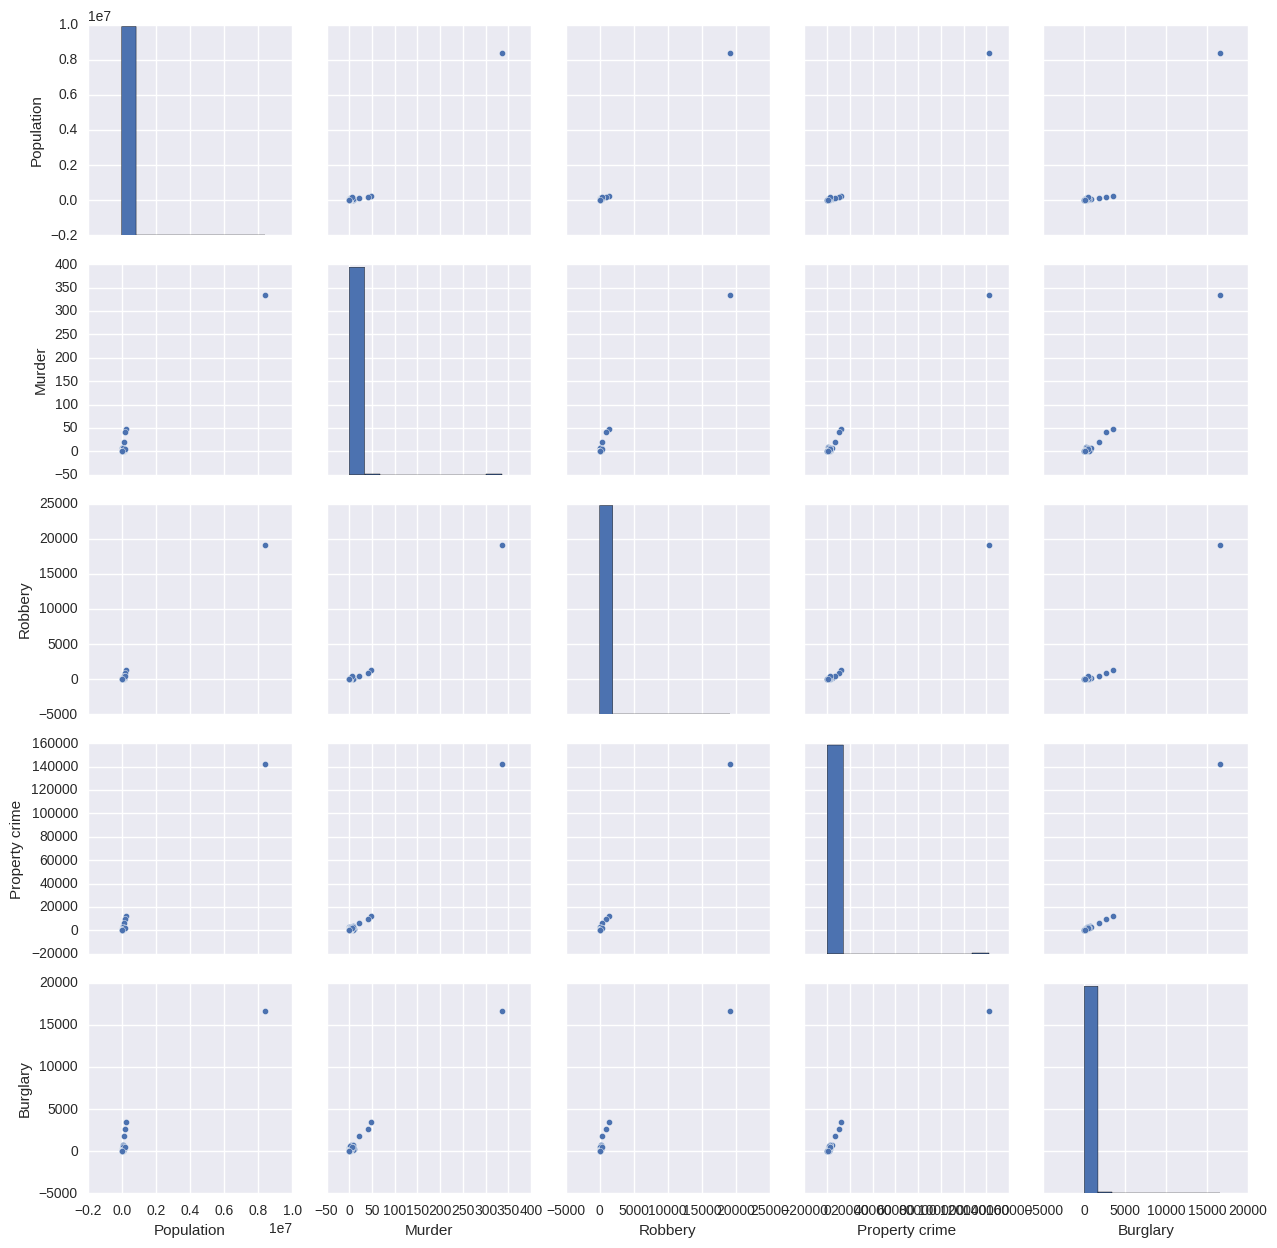

In [137]:
_ = sb.pairplot(data)

The 5 largest cities in New York State, New York City, Buffalo, Rochester, Syracuse and Yonkers are our skewing the distributions of all features. Will remove these data points and re visualize the plots. 

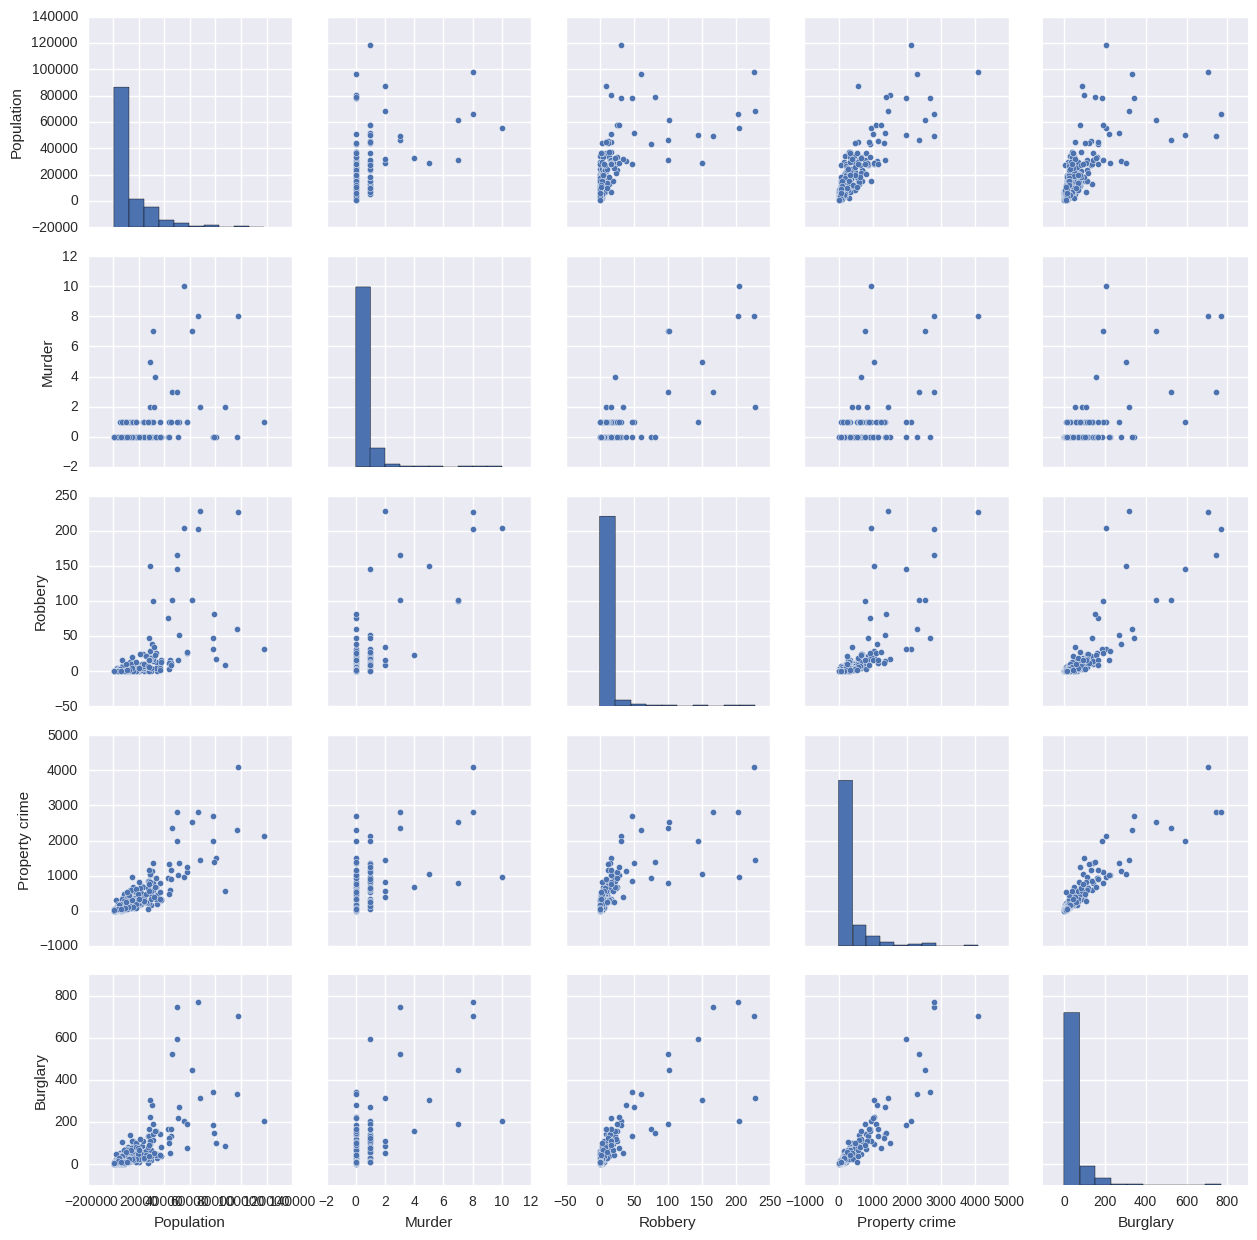

In [138]:
data = data[data.City != "New York"]
data = data[data.City != "Rochester"]
data = data[data.City != "Buffalo"]
data = data[data.City != "Syracuse"]
data = data[data.City != "Yonkers"]
_ = sb.pairplot(data)

There are many data points that have either 0 or 1 for the number of Murders and Robberies in 2103. This two Features will be will be converted to categorical features.

In [139]:
data["Murder_Cat"] = np.where(data.Murder == 0, 0, 1)
data["Robbery_Cat"] = np.where(data.Robbery == 0, 0, 1)
data.head()

,City,Population,Murder,Robbery,Property crime,Burglary,Murder_Cat,Robbery_Cat
0,Adams Village,1861,0,0,12,2,0,0
1,Addison Town and Village,2577,0,0,24,3,0,0
2,Akron Village,2846,0,0,16,1,0,0
3,Albany,97956,8,227,4090,705,1,1
4,Albion Village,6388,0,4,223,53,0,1


None of the Features have a distribution close to a normal distribution. Time to starting transforming the features to see how close we can theor distributions to normal.

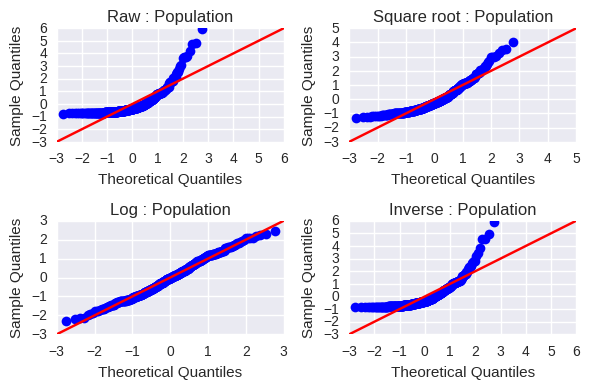

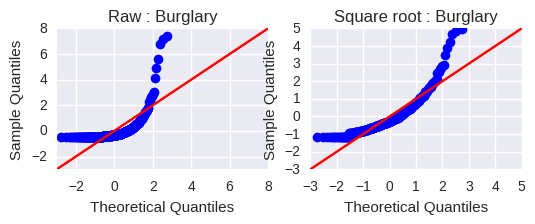

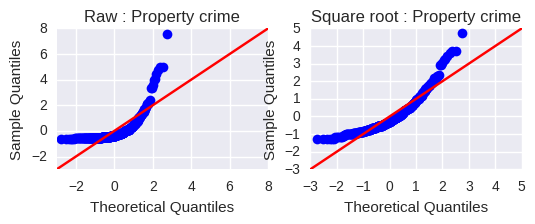

In [145]:
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(data.Population, line='45', fit=True, ax=ax)
ax.set_title('Raw : Population')

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(np.sqrt(data.Population), line='45', fit=True, ax=ax)
ax.set_title('Square root : Population')

ax = fig.add_subplot(2, 2, 3)
sm.graphics.qqplot(np.log(data.Population), line='45', fit=True, ax=ax)
ax.set_title('Log : Population')

ax = fig.add_subplot(2, 2, 4)
sm.graphics.qqplot(1/data.Population, line='45', fit=True, ax=ax)
ax.set_title('Inverse : Population')
plt.tight_layout()

# Burglary
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(data.Burglary, line='45', fit=True, ax=ax)
ax.set_title('Raw : Burglary')

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(np.sqrt(data.Burglary), line='45', fit=True, ax=ax)
ax.set_title('Square root : Burglary')

# Property crime
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(data['Property crime'], line='45', fit=True, ax=ax)
ax.set_title('Raw : Property crime')

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(np.sqrt(data['Property crime']), line='45', fit=True, ax=ax)
ax.set_title('Square root : Property crime')


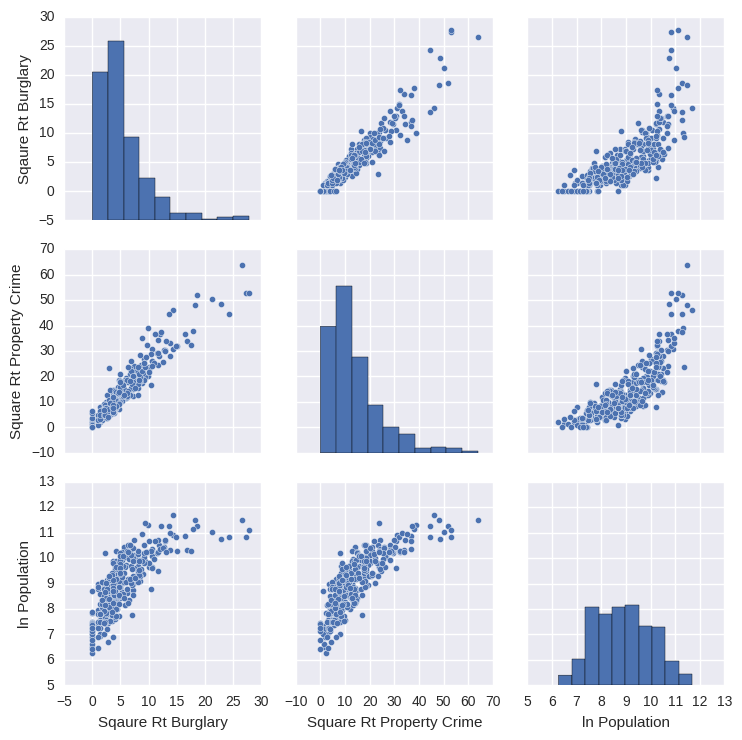

In [146]:
# Adding the log of the raw Population data points into data frame.
data['ln Population'] = np.log(data.Population)
data['Square Rt Property Crime'] = np.sqrt(data['Property crime'])
data['Sqaure Rt Burglary'] = np.sqrt(data.Burglary)
exclude = ['Population', 'Murder', 'Robbery', 'Murder_Cat', 'Robbery_Cat', 'Property crime', 'Burglary']
_ = sb.pairplot(data.ix[:, data.columns.difference(exclude)])